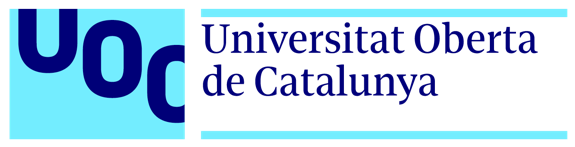

In [1]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np
import random
import scipy.stats as stats

# Librerías de visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 

# Librerías de procesaso de datos
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Otras librerías
import warnings
warnings.filterwarnings("ignore")

1. Carga de los datos

2. Generación dataset caso-control

3. Análisis dataset caso-control

4. Procesado de los datos

5. Guardado del dataset caso-control

6. Descripción variables finales

# 1. Carga de los dataos

In [2]:
file_path = "../data/DataBase.dat"
data = pd.read_csv(file_path, delim_whitespace = True)
data.head(5)

,ID,Episode_ID,Age,Time1,Time2,Timetotal,Family_History,BBD_History,Mammographic_Features,BreastCancer
0,1,1,56,",00","2,23","13,96",0,0,0,0
1,1,2,58,"2,23","4,01","13,96",0,1,0,0
2,1,3,60,"4,01","5,95","13,96",0,1,0,0
3,1,4,62,"5,95","7,98","13,96",0,1,0,0
4,1,5,64,"7,98","10,13","13,96",0,1,0,0


# 2. Generación dataset caso-control

Primero se muestras las funciones que hemos utilizado para la generación del dataset caso-control

In [3]:
def indexFinder(df_search, row, index_list, c=0):
    """
    # Función que busca el primer control por cada caso en base al identificador
    Args:
        df_search: dataset que contiene solo controles donde buscar
        row: fila del dataset de casos 
        index_list: lista de filas ya utilizadas
        c: índice que marca en que espisodio estamos
    """
    age_list = []
    if (len(index_list) > 0):
        df_search = df_search.drop(index_list, axis=0)
    
    if (c != 0):
        for col in columns:
            df_search = df_search.loc[(df_search[col] == row[col]) &
                                      (df_search['BreastCancer'] != row['BreastCancer']) &
                                     (df_search['ID'] == c)]
    else:
        for col in columns:
            df_search = df_search.loc[(df_search[col] == row[col]) &
                                      (df_search['BreastCancer'] != row['BreastCancer'])]
 

    return df_search if df_search.empty else df_search.head(1)

In [4]:
def findControl(df_controls, df_cases):
    """
    Función para iterar sobre los casos positivos y encontrar el control asociado a cada caso.
    Args:
        df_controls: dataset que contiene únicamente controles
        df_cases: dataset que contiene únicamente casos
    Returns:
        Dataframe con los controles encontrados
    """
    index_to_avoid = []
    to_delete = []
        
    for i in range(df_cases.shape[0]):
        
        # Se inicializa
        if (i == 0):
            row = indexFinder(df_controls, df_cases.iloc[i], index_to_avoid)
            df_control = row
        # Filas pertenecientes a la misma mujer (ID actual igual al ID anterior)
        elif (df_cases.iloc[i].ID == df_cases.iloc[i-1].ID):
            row = indexFinder(df_controls, df_cases.iloc[i], index_to_avoid, c = int(row.ID))
        # Casos en los que el ID es diferente
        else:
            row = indexFinder(df_controls, df_cases.iloc[i], index_to_avoid)
    
        if (row.empty):
            to_delete.append(df_cases.iloc[i].ID)
        else:
            df_control = pd.concat([df_control, row])
            index_to_avoid.append(row.index.values.astype(int)[0]) 
       
    return df_control.iloc[1: , :]

Se están borrando estas variables debido a que la correlación entre estas y la variable Episode_ID es muy alta (comprobar la correlación en el notebook ORIGINAL_DATASET_ANALYSIS.ipynb). En este caso vamos a dejar la variable ID para facilitarnos el agrupamiento.

In [5]:
# Se quitan las variabels que se van a usar
df = data.drop(['Time1', 'Time2', 'Timetotal'], axis = 1)

In [6]:
# Se extrae el número total de episodios por mujer

# Se agrupa por ID
df_by_id = df.groupby(["ID"]).count().reset_index()
df_by_id = df_by_id.drop(["Age", "Family_History", "BBD_History", "Mammographic_Features",
                               "BreastCancer"], axis = 1)

# Se renombran las columnas generadas
df_by_id.columns = ["ID", "Total_episodes"]

# Se jutan el dataset original con el agrupado por ID
df_grouped = df.merge(df_by_id, how = "left")

# Muestra del dataset final junto con la nueva variable que muestra el número total
# de episodios de cada mujer.
df_grouped.head(5)

,ID,Episode_ID,Age,Family_History,BBD_History,Mammographic_Features,BreastCancer,Total_episodes
0,1,1,56,0,0,0,0,7
1,1,2,58,0,1,0,0,7
2,1,3,60,0,1,0,0,7
3,1,4,62,0,1,0,0,7
4,1,5,64,0,1,0,0,7


Para crear el dataset caso-control se va a proceder primero a separar los casos positivos de los negativos.

In [7]:
# Casos positivos
case_data = df_grouped[df_grouped['BreastCancer'] == 1]

# Casos positivos
whole_control_data = df_grouped[df_grouped['BreastCancer'] == 0]

In [8]:
# Variables para encontrar el control por cada caso en base al episodio
columns = ['Episode_ID', 'Total_episodes']

# Ejecución de la función para generar el dataset de controles
control_data = findControl(whole_control_data, case_data)
control_data.head()

,ID,Episode_ID,Age,Family_History,BBD_History,Mammographic_Features,BreastCancer,Total_episodes
10,3,1,58,0,0,0,0,2
11,3,2,61,0,0,0,0,2
7,2,1,64,0,1,0,0,3
8,2,2,66,0,1,0,0,3
9,2,3,67,0,1,0,0,3


In [9]:
# Se crea el dataset final caso-control
whole_data = pd.concat([case_data, control_data])

print('Casos total mujeres: ', len(case_data['ID'].unique()))
print('Total muestras casos : ', case_data.shape[0])

print('Control total mujeres: ', len(control_data['ID'].unique()))
print('Total muestras controles : ', control_data.shape[0])

whole_data.head()

Casos total mujeres:  2058
Total muestras casos :  6050
Control total mujeres:  2058
Total muestras controles :  6050


,ID,Episode_ID,Age,Family_History,BBD_History,Mammographic_Features,BreastCancer,Total_episodes
375,76,1,50,0,0,0,1,2
376,76,2,52,0,1,0,1,2
490,101,1,51,0,0,0,1,3
491,101,2,53,0,0,0,1,3
492,101,3,55,0,0,0,1,3


# 3. Análisis dataset caso-control

In [10]:
df_mean_total = whole_data.groupby(["ID"]).mean()
df_mean_cancer_free = whole_data[whole_data['BreastCancer'] == 0].groupby(["ID"]).mean()
df_mean_cancer = whole_data[whole_data['BreastCancer'] == 1].groupby(["ID"]).mean()

In [11]:
print("La edad media del total de mujeres del dataset es: "
      "{:.2f}".format(df_mean_total.describe()["Age"]["mean"]))
print("La edad media de las mujeres que no han desarrollado cáncer de mama es: "
      "{:.2f}".format(df_mean_cancer_free.describe()["Age"]["mean"]))
print("La edad media de las mujeres que sí han desarrollado cáncer de mama es: "
      "{:.2f}".format(df_mean_cancer.describe()["Age"]["mean"]))

La edad media del total de mujeres del dataset es: 56.75
La edad media de las mujeres que no han desarrollado cáncer de mama es: 56.74
La edad media de las mujeres que sí han desarrollado cáncer de mama es: 56.76


In [12]:
print("Media de episodios del total de mujeres del dataset: "
      "{:.2f}".format(df_mean_total.describe()["Episode_ID"]["mean"]))
print("Media de episodios de las mujeres que no han desarrollado cáncer de mama: "
      "{:.2f}".format(df_mean_cancer_free.describe()["Episode_ID"]["mean"]))
print("Media de episodios de las mujeres que han desarrollado cáncer de mama: "
      "{:.2f}".format(df_mean_cancer.describe()["Episode_ID"]["mean"]))

Media de episodios del total de mujeres del dataset: 1.97
Media de episodios de las mujeres que no han desarrollado cáncer de mama: 1.97
Media de episodios de las mujeres que han desarrollado cáncer de mama: 1.97


In [13]:
# Se agrupa el dataset de nuevo para valorar los factores de riesgo
# Se escoge el último episodio por cada mujer

df = whole_data.groupby(['ID']).agg(list)
df_np = df.to_numpy()
def parseRows(row):
    patient_length = len(row[0])
    parsed_row = [x[patient_length - 1] for x in row]
    return parsed_row

parsed_np = np.apply_along_axis(parseRows, axis = 1, arr = df_np)

df_converted = pd.DataFrame(parsed_np, columns = ["Episode_ID", "Age", "Family_History",
                                                  "BBD_History", "Mammographic_Features",
                                                 "BreastCancer", "Total_episodes"])
print(df_converted.shape)

# Último episodio por mujer
df_converted.head()

(4116, 7)


,Episode_ID,Age,Family_History,BBD_History,Mammographic_Features,BreastCancer,Total_episodes
0,7,68,0,1,0,0,7
1,3,67,0,1,0,0,3
2,2,61,0,0,0,0,2
3,5,68,0,0,0,0,5
4,6,61,0,1,0,0,6


In [14]:
unique_control = df_converted[df_converted["BreastCancer"] == 0]
unique_case = df_converted[df_converted["BreastCancer"] == 1]

In [15]:
fh_no_control = unique_control[unique_control['Family_History'] == 0]
fh_yes_control = unique_control[unique_control['Family_History'] == 1]
fh_no_case = unique_case[unique_case['Family_History'] == 0]
fh_yes_case = unique_case[unique_case['Family_History'] == 1]

print("Casos - Porcentaje de Family_History negativo : "
      "{:.2f} - {:.2f} %".format(fh_no_case.shape[0],
                                 fh_no_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de Family_History positivo : "
      "{:.2f} - {:.2f} %".format(fh_yes_case.shape[0],
                                 fh_yes_case.shape[0]*100/unique_case.shape[0]))
print("Controles - Porcentaje de Family_History negativo : "
      "{:.2f} - {:.2f} %".format(fh_no_control.shape[0],
                                 fh_no_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de Family_History positivo : "
      "{:.2f} -  {:.2f} %".format(fh_yes_control.shape[0],
                                  fh_yes_control.shape[0]*100/unique_control.shape[0]))

Casos - Porcentaje de Family_History negativo : 1681.00 - 81.68 %
Casos - Porcentaje de Family_History positivo : 377.00 - 18.32 %
Controles - Porcentaje de Family_History negativo : 1718.00 - 83.48 %
Controles - Porcentaje de Family_History positivo : 340.00 -  16.52 %


In [16]:
bbd_none_control = unique_control[unique_control['BBD_History'] == 0]
bbd_unknown_control = unique_control[unique_control['BBD_History'] == 1]
bbd_no_proliferative_control = unique_control[unique_control['BBD_History'] == 2]
bbd_proliferative_control = unique_control[unique_control['BBD_History'] == 3]
bbd_none_case = unique_case[unique_case['BBD_History'] == 0]
bbd_unknown_case = unique_case[unique_case['BBD_History'] == 1]
bbd_no_proliferative_case = unique_case[unique_case['BBD_History'] == 2]
bbd_proliferative_case = unique_case[unique_case['BBD_History'] == 3]

print("Controles - Porcentaje de BBD_History ninguno : "
      "{:.2f} - {:.2f} %".format(bbd_none_control.shape[0],
                                 bbd_none_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de BBD_History desconocido : "
      "{:.2f} - {:.2f} %".format(bbd_unknown_control.shape[0],
                                 bbd_unknown_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de BBD_History no proliferative : "
      "{:.2f} - {:.2f} %".format(bbd_no_proliferative_control.shape[0],
                                 bbd_no_proliferative_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de BBD_History proliferative : "
      "{:.2f} - {:.2f} %".format(bbd_proliferative_control.shape[0],
                                 bbd_proliferative_control.shape[0]*100/unique_control.shape[0]))
print("Casos - Porcentaje de BBD_History ninguno : "
      "{:.2f} - {:.2f} %".format(bbd_none_case.shape[0],
                                 bbd_none_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de BBD_History desconocido : "
      "{:.2f} - {:.2f} %".format(bbd_unknown_case.shape[0],
                                 bbd_unknown_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de BBD_History no proliferative : "
      "{:.2f} - {:.2f} %".format(bbd_no_proliferative_case.shape[0],
                                 bbd_no_proliferative_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de BBD_History proliferative : "
      "{:.2f} - {:.2f} %".format(bbd_proliferative_case.shape[0],
                                 bbd_proliferative_case.shape[0]*100/unique_case.shape[0]))

Controles - Porcentaje de BBD_History ninguno : 1612.00 - 78.33 %
Controles - Porcentaje de BBD_History desconocido : 390.00 - 18.95 %
Controles - Porcentaje de BBD_History no proliferative : 54.00 - 2.62 %
Controles - Porcentaje de BBD_History proliferative : 2.00 - 0.10 %
Casos - Porcentaje de BBD_History ninguno : 1421.00 - 69.05 %
Casos - Porcentaje de BBD_History desconocido : 489.00 - 23.76 %
Casos - Porcentaje de BBD_History no proliferative : 115.00 - 5.59 %
Casos - Porcentaje de BBD_History proliferative : 33.00 - 1.60 %


In [17]:
mf_none_control = unique_control[unique_control['Mammographic_Features'] == 0]
mf_mass_control = unique_control[unique_control['Mammographic_Features'] == 1]
mf_calc_control = unique_control[unique_control['Mammographic_Features'] == 2]
mf_asyn_den_control = unique_control[unique_control['Mammographic_Features'] == 3]
mf_dist_control = unique_control[unique_control['Mammographic_Features'] == 4]
mf_pm_control = unique_control[unique_control['Mammographic_Features'] == 5]

mf_none_case = unique_case[unique_case['Mammographic_Features'] == 0]
mf_mass_case = unique_case[unique_case['Mammographic_Features'] == 1]
mf_calc_case = unique_case[unique_case['Mammographic_Features'] == 2]
mf_asyn_den_case = unique_case[unique_case['Mammographic_Features'] == 3]
mf_dist_case = unique_case[unique_case['Mammographic_Features'] == 4]
mf_pm_case = unique_case[unique_case['Mammographic_Features'] == 5]

print("Controles - Porcentaje de Mammographic_Features ninguno : "
      "{:.2f} - {:.2f} %".format(mf_none_control.shape[0],
                                 mf_none_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de Mammographic_Features masa : "
      "{:.2f} - {:.2f} %".format(mf_mass_control.shape[0],
                                 mf_mass_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de Mammographic_Features calcificaciones : "
      "{:.2f} - {:.2f} %".format(mf_calc_control.shape[0],
                                 mf_calc_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de Mammographic_Features densidad asimétrica : "
      "{:.2f} - {:.2f} %".format(mf_asyn_den_control.shape[0],
                                 mf_asyn_den_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de Mammographic_Features distorsión : "
      "{:.2f} - {:.2f} %".format(mf_dist_control.shape[0],
                                 mf_dist_control.shape[0]*100/unique_control.shape[0]))
print("Controles - Porcentaje de Mammographic_Features patrón múltiple : "
      "{:.2f} - {:.2f} %".format(mf_pm_control.shape[0],
                                 mf_pm_control.shape[0]*100/unique_case.shape[0]))

print("Casos - Porcentaje de Mammographic_Features ninguno : "
      "{:.2f} - {:.2f} %".format(mf_none_case.shape[0],
                                 mf_none_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de Mammographic_Features masa : "
      "{:.2f} - {:.2f} %".format(mf_mass_case.shape[0],
                                 mf_mass_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de Mammographic_Features calcificaciones : "
      "{:.2f} - {:.2f} %".format(mf_calc_case.shape[0],
                                 mf_calc_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de Mammographic_Features densidad asimétrica : "
      "{:.2f} - {:.2f} %".format(mf_asyn_den_case.shape[0],
                                 mf_asyn_den_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de Mammographic_Features distorsión : "
      "{:.2f} - {:.2f} %".format(mf_dist_case.shape[0],
                                 mf_dist_case.shape[0]*100/unique_case.shape[0]))
print("Casos - Porcentaje de Mammographic_Features patrón múltiple : "
      "{:.2f} - {:.2f} %".format(mf_pm_case.shape[0],
                                 mf_pm_case.shape[0]*100/unique_case.shape[0]))

Controles - Porcentaje de Mammographic_Features ninguno : 1658.00 - 80.56 %
Controles - Porcentaje de Mammographic_Features masa : 244.00 - 11.86 %
Controles - Porcentaje de Mammographic_Features calcificaciones : 29.00 - 1.41 %
Controles - Porcentaje de Mammographic_Features densidad asimétrica : 54.00 - 2.62 %
Controles - Porcentaje de Mammographic_Features distorsión : 26.00 - 1.26 %
Controles - Porcentaje de Mammographic_Features patrón múltiple : 47.00 - 2.28 %
Casos - Porcentaje de Mammographic_Features ninguno : 1283.00 - 62.34 %
Casos - Porcentaje de Mammographic_Features masa : 422.00 - 20.51 %
Casos - Porcentaje de Mammographic_Features calcificaciones : 141.00 - 6.85 %
Casos - Porcentaje de Mammographic_Features densidad asimétrica : 56.00 - 2.72 %
Casos - Porcentaje de Mammographic_Features distorsión : 29.00 - 1.41 %
Casos - Porcentaje de Mammographic_Features patrón múltiple : 127.00 - 6.17 %


## 3.1 Contraste de hipótesis

### Variables numéricas

###### Variable Age casos

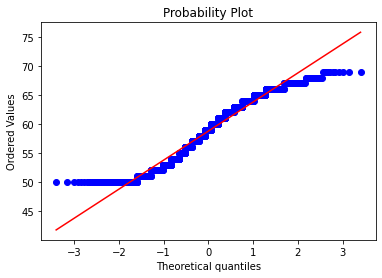

In [18]:
# Visualización distribución variable Age para las mujeres tipo control
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(unique_case["Age"], dist="norm", plot=pylab)
pylab.show()

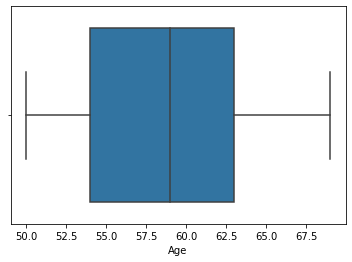

In [19]:
# Diagrama de caja para distribución variable Age para las mujeres tipo control
ax = sns.boxplot(x=unique_case["Age"])

In [20]:
# Test de normalidad para variable Age en mujeres tipo control

# Se aplica el test Shapiro-Wilk
print("Test de normalidad de Shapiro-Wilk", stats.shapiro(unique_case["Age"]))

# Se genera una variable con distribución normal en base a la variable a comprobar
loc, scale = stats.norm.fit(unique_case["Age"])
n = stats.norm(loc=loc, scale=scale)

# Se aplica el test Kolmogorov–Smirnov
print("Test de normalidad de Kolmogorov–Smirnov", stats.kstest(unique_case["Age"], n.cdf))

Test de normalidad de Shapiro-Wilk ShapiroResult(statistic=0.9582453370094299, pvalue=7.366689999845939e-24)
Test de normalidad de Kolmogorov–Smirnov KstestResult(statistic=0.09062793274451086, pvalue=3.693581130567345e-15)


La variable Age para los casos no sigue la distribución normal.

##### Variable Age controles

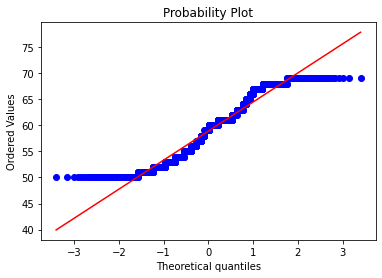

In [21]:
import pylab 
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(unique_control["Age"], dist="norm", plot=pylab)
pylab.show()

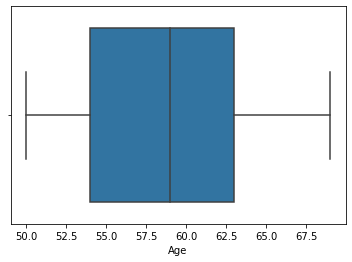

In [22]:
ax = sns.boxplot(x=unique_control["Age"])

In [23]:
print("Test de normalidad de Shapiro-Wilk", stats.shapiro(unique_control["Age"]))

# Se genera una variable con distribución normal en base a la variable a comprobar
loc, scale = stats.norm.fit(unique_control["Age"])
n = stats.norm(loc=loc, scale=scale)

# Se aplica el test Kolmogorov–Smirnov
print("Test de normalidad de Kolmogorov–Smirnov", stats.kstest(unique_control["Age"], n.cdf))

Test de normalidad de Shapiro-Wilk ShapiroResult(statistic=0.9455763101577759, pvalue=6.4428904801563956e-27)
Test de normalidad de Kolmogorov–Smirnov KstestResult(statistic=0.10178331210470881, pvalue=5.14998511945792e-19)


La variable Age para los controles no sigue la distribución normal.

**Por lo que para la comparación de muestras en el caso de la variable Age se va a utilizar el test U de Mann-Whitney**

In [24]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(unique_case["Age"], unique_control["Age"])
print("El p-value para Edad es: ", p)

El p-value para Edad es:  0.9975368072082446


### Variables categóricas

##### Family_History

In [25]:
count_case = [unique_case[unique_case["Family_History"] == 1]["Family_History"].count(),
        unique_case[unique_case["Family_History"] == 0]["Family_History"].count()]
control_case = [unique_control[unique_control["Family_History"] == 1]["Family_History"].count(),
        unique_control[unique_control["Family_History"] == 0]["Family_History"].count()]

ar=np.array([count_case, control_case])    
df=pd.DataFrame(ar, columns=["Family_History_Yes", "Family_History_No"])
df.index=["cases", "controls"] 
df 

,Family_History_Yes,Family_History_No
cases,377,1681
controls,340,1718


In [26]:
df2=df.copy() # create contingency table with the marginal totals and the grand total. 
df2.loc['Column_Total']= df2.sum(numeric_only=True, axis=0)
df2.loc[:,'Row_Total'] = df2.sum(numeric_only=True, axis=1)
df2

,Family_History_Yes,Family_History_No,Row_Total
cases,377,1681,2058
controls,340,1718,2058
Column_Total,717,3399,4116


In [27]:
tstat, pval, ddof, exp = stats.chi2_contingency(df, correction=False)
print("El p-value para Family_History es: " + str(pval))

El p-value para Family_History es: 0.12836968863248618


##### BBD_History

In [28]:
count_case = [unique_case[unique_case["Family_History"] == 0]["BBD_History"].count(),
        unique_case[unique_case["BBD_History"] == 1]["BBD_History"].count(),
        unique_case[unique_case["BBD_History"] == 2]["BBD_History"].count(),
        unique_case[unique_case["BBD_History"] == 3]["BBD_History"].count()]
control_case = [unique_control[unique_control["Family_History"] == 0]["BBD_History"].count(),
        unique_control[unique_control["BBD_History"] == 1]["BBD_History"].count(),
        unique_control[unique_control["BBD_History"] == 2]["BBD_History"].count(),
        unique_control[unique_control["BBD_History"] == 3]["BBD_History"].count()]

ar=np.array([count_case, control_case])    
df=pd.DataFrame(ar, columns=["bbd_none", "bbd_unknown", "bbd_noproliferative", "bbd_proliferative"])
df.index=["cases", "controls"] 
df 

,bbd_none,bbd_unknown,bbd_noproliferative,bbd_proliferative
cases,1681,489,115,33
controls,1718,390,54,2


In [29]:
df2=df.copy() # create contingency table with the marginal totals and the grand total. 
df2.loc['Column_Total']= df2.sum(numeric_only=True, axis=0)
df2.loc[:,'Row_Total'] = df2.sum(numeric_only=True, axis=1)
df2

,bbd_none,bbd_unknown,bbd_noproliferative,bbd_proliferative,Row_Total
cases,1681,489,115,33,2318
controls,1718,390,54,2,2164
Column_Total,3399,879,169,35,4482


In [30]:
tstat, pval, ddof, exp = stats.chi2_contingency(df, correction=False)
print("El p-value para BBD_History es: " + str(pval))

El p-value para BBD_History es: 4.629450643349058e-12


##### Mammographic_Features

In [31]:
count_case = [unique_case[unique_case["Mammographic_Features"] == 0]["Mammographic_Features"].count(),
        unique_case[unique_case["Mammographic_Features"] == 1]["Mammographic_Features"].count(),
        unique_case[unique_case["Mammographic_Features"] == 2]["Mammographic_Features"].count(),
        unique_case[unique_case["Mammographic_Features"] == 3]["Mammographic_Features"].count(),
        unique_case[unique_case["Mammographic_Features"] == 4]["Mammographic_Features"].count(),
        unique_case[unique_case["Mammographic_Features"] == 5]["Mammographic_Features"].count()]
control_case = [unique_control[unique_control["Mammographic_Features"] == 0]["Mammographic_Features"].count(),
        unique_control[unique_control["Mammographic_Features"] == 1]["Mammographic_Features"].count(),
        unique_control[unique_control["Mammographic_Features"] == 2]["Mammographic_Features"].count(),
        unique_control[unique_control["Mammographic_Features"] == 3]["Mammographic_Features"].count(),
        unique_control[unique_control["Mammographic_Features"] == 4]["Mammographic_Features"].count(),
        unique_control[unique_control["Mammographic_Features"] == 5]["Mammographic_Features"].count()]

ar=np.array([count_case, control_case])    
df=pd.DataFrame(ar, columns=["mf_none", "mf_mass", "mf_calcification", "mf_asymetric_density",
                            "mf_distortion", "mf_patron_multipla"])
df.index=["cases", "controls"] 
df 

,mf_none,mf_mass,mf_calcification,mf_asymetric_density,mf_distortion,mf_patron_multipla
cases,1283,422,141,56,29,127
controls,1658,244,29,54,26,47


In [32]:
df2=df.copy() # create contingency table with the marginal totals and the grand total. 
df2.loc['Column_Total']= df2.sum(numeric_only=True, axis=0)
df2.loc[:,'Row_Total'] = df2.sum(numeric_only=True, axis=1)
df2

,mf_none,mf_mass,mf_calcification,mf_asymetric_density,mf_distortion,mf_patron_multipla,Row_Total
cases,1283,422,141,56,29,127,2058
controls,1658,244,29,54,26,47,2058
Column_Total,2941,666,170,110,55,174,4116


In [33]:
tstat, pval, ddof, exp = stats.chi2_contingency(df, correction=False)
print("El p-value para Mammographic_Features es: " + str(pval))

El p-value para Mammographic_Features es: 1.3665141226491768e-42


# 4. Procesado de los datos

In [34]:
# Se desordena los dataos
whole_data = whole_data.sample(frac=1).reset_index(drop=True)

# Variables que no se necesitan 
whole_data = whole_data.drop(['ID', 'Total_episodes'], axis = 1)

# Refactorizamos las variables al tipo adecuado
whole_data['Episode_ID'] = whole_data['Episode_ID'].astype('float')
whole_data['Family_History'] = whole_data['Family_History'].astype('float')
whole_data['BBD_History'] = whole_data['BBD_History'].astype('float')
whole_data['Mammographic_Features'] = whole_data['Mammographic_Features'].astype('float')
whole_data['BreastCancer'] = whole_data['BreastCancer'].astype('float')

# Rearreglo de las columnas
whole_data = whole_data[['BreastCancer', 'Episode_ID', 'Age', 'Family_History', 'BBD_History',
                             'Mammographic_Features']]

In [35]:
# Se aplica la codificación one-hot encoder a todas aquellas variables categóricas con más
# de dos clases para convertirlas a tipo numérico
onehot_encoder = OneHotEncoder()

episode_id_df = pd.DataFrame(onehot_encoder.fit_transform(whole_data[['Episode_ID']]).toarray())
episode_id_df.columns = ['episode_1', 'episode_2', 'episode_3', 'episode_4',
                          'episode_5', 'episode_6', 'episode_7', 'episode_8', 'episode_9', 'episode_10']

bbd_history_df = pd.DataFrame(onehot_encoder.fit_transform(whole_data[['BBD_History']]).toarray())
bbd_history_df.columns = ['bbd_none', 'bbd_unknown', 'bbd_no_proliferative', 'bbd_proliferative']

mammographic_features_df = pd.DataFrame(onehot_encoder.fit_transform(whole_data[['Mammographic_Features']]).toarray())
mammographic_features_df.columns = ['mf_none', 'mf_mass', 'mf_calcification', 'mf_asymetric_density',
                           'mf_distorsion', 'mf_multiple_patron']

whole_data = whole_data.drop(['Episode_ID', 'BBD_History', 'Mammographic_Features'], axis = 1)

whole_data = pd.concat([whole_data, episode_id_df, bbd_history_df, mammographic_features_df], axis = 1)

whole_data.head()

,BreastCancer,Age,Family_History,episode_1,episode_2,episode_3,episode_4,episode_5,episode_6,episode_7,...,bbd_none,bbd_unknown,bbd_no_proliferative,bbd_proliferative,mf_none,mf_mass,mf_calcification,mf_asymetric_density,mf_distorsion,mf_multiple_patron
0,1.0,63,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,54,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,57,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,61,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Se escala la variable Age
scaler = MinMaxScaler()
whole_data['Age'] = scaler.fit_transform(whole_data[['Age']])
whole_data.head()

,BreastCancer,Age,Family_History,episode_1,episode_2,episode_3,episode_4,episode_5,episode_6,episode_7,...,bbd_none,bbd_unknown,bbd_no_proliferative,bbd_proliferative,mf_none,mf_mass,mf_calcification,mf_asymetric_density,mf_distorsion,mf_multiple_patron
0,1.0,0.684211,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.789474,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.210526,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.368421,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.578947,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 5. Guardado del dataset

In [37]:
# Se guarda el nuevo dataseat
whole_data.to_csv ('../data/case_control_episode.csv', index = False, header=True)

# 6. Descripción variables finales

Descripción de las variables que conforman el dataset caso-control:


- `ID`: variable identificativa para cada mujer
- `Episode_ID`: identificador asociado al episodio (mamografía) de cada mujer, ordenados cronológicamente
- `Age`: edad de la mujer estandarizada
- `Family_History`: historia familiar de antecedentes de cáncer de mama (familiar de primer grado)
    - 0: No hay antecedentes
    - 1: Si
- `episode_1`: Muestra asociada al episodio 1
    - 0: No
    - 1: Si
- `episode_2`: Muestra asociada al episodio 2
    - 0: No
    - 1: Si
- `episode_3`: Muestra asociada al episodio 3
    - 0: No
    - 1: Si
- `episode_4`: Muestra asociada al episodio 4
    - 0: No
    - 1: Si
- `episode_5`: Muestra asociada al episodio 5
    - 0: No
    - 1: Si
- `episode_6`: Muestra asociada al episodio 6
    - 0: No
    - 1: Si
- `episode_7`: Muestra asociada al episodio 7
    - 0: No
    - 1: Si
- `episode_8`: Muestra asociada al episodio 8
    - 0: No
    - 1: Si
- `episode_9`: Muestra asociada al episodio 9
    - 0: No
    - 1: Si
- `episode_10`: Muestra asociada al episodio 10
    - 0: No
    - 1: Si
- `bbd_none`: Antecedentes personales de lesión benigna de ningún tipo
    - 0: No
    - 1: Si
- `bbd_unknown`: Antecedentes personales de lesión benigna desconocidos
    - 0: No
    - 1: Si
- `bbd_no_proliferative`: Antecedentes personales de lesión benigna no proliferativos
    - 0: No
    - 1: Si
- `bbd_proliferative`: Antecedentes personales de lesión benigna proliferativos
    - 0: No
    - 1: Si
- `mf_none`: Antecedentes personales de patrones mamográficos de ningún tipo
    - 0: No
    - 1: Si
- `mf_mass`: Antecedentes personales de patrones mamográficos tipo masa
    - 0: No
    - 1: Si
- `mf_calcification`: Antecedentes personales de patrones mamográficos tipo calcificación
    - 0: No
    - 1: Si
- `mf_asymetric_density`: Antecedentes personales de patrones mamográficos tipo desnsidad asimétrica
    - 0: No
    - 1: Si
- `mf_distorsion`: Antecedentes personales de patrones mamográficos tipo distorsión
    - 0: No
    - 1: Si
- `mf_multiple_patron`: Antecedentes personales de patrones mamográficos tipo patrón múltipla
    - 0: No
    - 1: Si
- `BreastCancer`:
    - 0: No
    - 1: Si